In [1]:

import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob
#from sklearn.model_selection import KFold
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
os.environ['CUDA_VISIBLE_DEVICES']="0"
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.2
set_session(tf.Session(config=config))



#DATA_DIR = '/kaggle/input'
DATA_DIR = '/data/krf/dataset'
# Directory to save logs and trained model
#ROOT_DIR = '/kaggle/working'
ROOT_DIR = '/data/krf/model/rsna'

# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

train_dicom_dir = os.path.join(DATA_DIR, 'stage_1_train_images')
test_dicom_dir = os.path.join(DATA_DIR, 'stage_1_test_images')

COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 



# The following parameters have been selected to reduce running time for demonstration purposes 
# These are not optimal 

class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    RPN_ANCHOR_SCALES = ( 32, 64, 128,256)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 5
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.4  ## match target distribution
    DETECTION_NMS_THRESHOLD = 0.1

    STEPS_PER_EPOCH = 1024

config = DetectorConfig()
config.display()

class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
        
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

# training dataset
anns = pd.read_csv(os.path.join(DATA_DIR, 'stage_1_train_labels.csv'))
anns.head()


image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)

ds = pydicom.read_file(image_fps[0]) # read dicom image from filepath 
image = ds.pixel_array # get image array

# Original DICOM image size: 1024 x 1024
ORIG_SIZE = 1024

image_fps_list = list(image_fps)
random.seed(42)
random.shuffle(image_fps_list)
val_size = 1500
image_fps_val = image_fps_list[:val_size]
image_fps_train = image_fps_list[val_size:]

print(len(image_fps_train), len(image_fps_val))
# print(image_fps_val[:6])

# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

# Show annotation(s) for a DICOM image 
test_fp = random.choice(image_fps_train)
image_annotations[test_fp]

# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()


# Load and display random sample and their bounding boxes

class_ids = [0]
while class_ids[0] == 0:  ## look for a mask
    image_id = random.choice(dataset_train.image_ids)
    image_fp = dataset_train.image_reference(image_id)
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

# Image augmentation (light but constant)
augmentation = iaa.Sequential([
    iaa.OneOf([ ## geometric transform
        iaa.Affine(
            scale={"x": (0.98, 1.02), "y": (0.98, 1.04)},
            translate_percent={"x": (-0.02, 0.02), "y": (-0.04, 0.04)},
            rotate=(-2, 2),
            shear=(-1, 1),
        ),
        iaa.PiecewiseAffine(scale=(0.001, 0.025)),
    ]),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ]),
])

# test on the same image as above
imggrid = augmentation.draw_grid(image[:, :, 0], cols=5, rows=2)
plt.figure(figsize=(30, 12))
_ = plt.imshow(imggrid[:, :, 0], cmap='gray')


# model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

# # Exclude the last layers because they require a matching
# # number of classes
# model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
#     "mrcnn_class_logits", "mrcnn_bbox_fc",
#     "mrcnn_bbox", "mrcnn_mask"])



# LEARNING_RATE = 0.002

# # Train Mask-RCNN Model 
# import warnings 
# warnings.filterwarnings("ignore")


# ## train heads with higher lr to speedup the learning
# model.train(dataset_train, dataset_val,
#             learning_rate=LEARNING_RATE*2,
#             epochs=2,
#             layers='heads',
#             augmentation=None)  ## no need to augment yet

# history = model.keras_model.history.history


# model.train(dataset_train, dataset_val,
#             learning_rate=LEARNING_RATE,
#             epochs=6,
#             layers='all',
#             augmentation=augmentation)

# new_history = model.keras_model.history.history
# for k in new_history: history[k] = history[k] + new_history[k]


# model.train(dataset_train, dataset_val,
#             learning_rate=LEARNING_RATE/5,
#             epochs=20,
#             layers='all',
#             augmentation=augmentation)

# new_history = model.keras_model.history.history
# for k in new_history: history[k] = history[k] + new_history[k]

# model.train(dataset_train, dataset_val,
#             learning_rate = 0.0001,
#             epochs=40,
#             layers='all',
#             augmentation=augmentation)
# new_history = model.keras_model.history.history
# for k in new_history: history[k] = history[k] + new_history[k]

# model.train(dataset_train, dataset_val,
#             learning_rate = 0.00001,
#             epochs=60,
#             layers='all',
#             augmentation=augmentation)
# new_history = model.keras_model.history.history
# for k in new_history: history[k] = history[k] + new_history[k]

# epochs = range(1,len(next(iter(history.values())))+1)
# pd.DataFrame(history, index=epochs)


# plt.figure(figsize=(17,5))

# plt.subplot(131)
# plt.plot(epochs, history["loss"], label="Train loss")
# plt.plot(epochs, history["val_loss"], label="Valid loss")
# plt.legend()
# plt.subplot(132)
# plt.plot(epochs, history["mrcnn_class_loss"], label="Train class ce")
# plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid class ce")
# plt.legend()
# plt.subplot(133)
# plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train box loss")
# plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid box loss")
# plt.legend()

# plt.show()
# plt.savefig(ROOT_DIR+"/log.png")

# best_epoch = np.argmin(history["val_loss"])
# print("Best Epoch:", best_epoch + 1)




Using TensorFlow backend.



Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.4
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'rpn_class_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

['mask_rcnn_pneumonia_0031.h5', 'mask_rcnn_pneumonia_0032.h5', 'mask_rcnn_pneumonia_0033.h5', 'mask_rcnn_pneumonia_0034.h5', 'mask_rcnn_pneumonia_0035.h5', 'mask_rcnn_pneumonia_0036.h5', 'mask_rcnn_pneumonia_0037.h5', 'mask_rcnn_pneumonia_0038.h5', 'mask_rcnn_pneumonia_0039.h5', 'mask_rcnn_pneumonia_0040.h5', 'mask_rcnn_pneumonia_0041.h5', 'mask_rcnn_pneumonia_0042.h5', 'mask_rcnn_pneumonia_0043.h5', 'mask_rcnn_pneumonia_0044.h5', 'mask_rcnn_pneumonia_0045.h5', 'mask_rcnn_pneumonia_0046.h5', 'mask_rcnn_pneumonia_0047.h5', 'mask_rcnn_pneumonia_0048.h5', 'mask_rcnn_pneumonia_0049.h5', 'mask_rcnn_pneumonia_0050.h5', 'mask_rcnn_pneumonia_0051.h5', 'mask_rcnn_pneumonia_0052.h5', 'mask_rcnn_pneumonia_0053.h5', 'mask_rcnn_pneumonia_0054.h5', 'mask_rcnn_pneumonia_0055.h5', 'mask_rcnn_pneumonia_0056.h5', 'mask_rcnn_pneumonia_0057.h5', 'mask_rcnn_pneumonia_0058.h5', 'mask_rcnn_pneumonia_0059.h5', 'mask_rcnn_pneumonia_0060.h5']
Found model /data/krf/model/rsna/pneumonia20181013T1301/mask_rcnn_pne

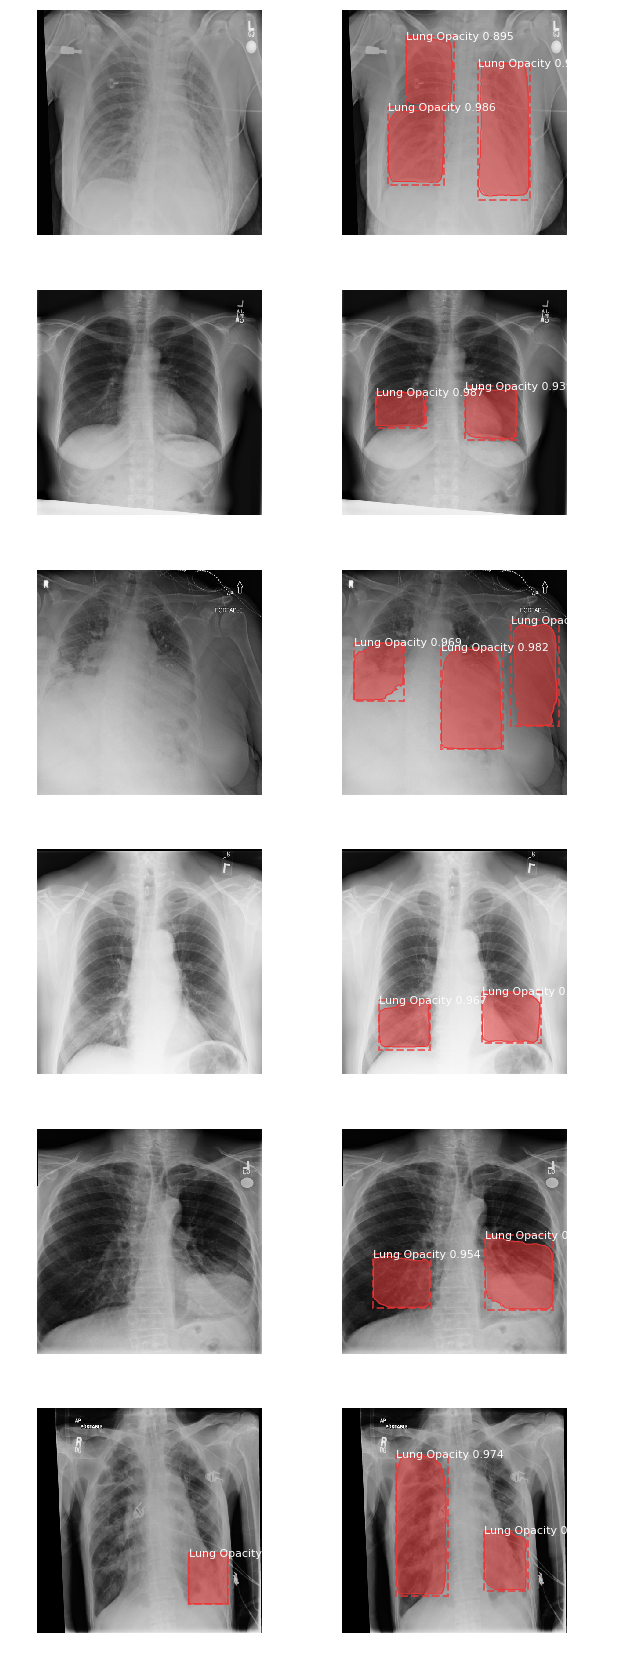

In [2]:
## select trained model 
model_dir = ROOT_DIR
dir_names = next(os.walk(model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(model_dir))
    
fps = []
# Pick last directory
#for d in dir_names: 
best_epoch = 40-31

d = dir_names[3]    
dir_name = os.path.join(model_dir, d)
# Find the last checkpoint
checkpoints = next(os.walk(dir_name))[2]
#print(checkpoints)
checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
checkpoints = sorted(checkpoints)
if not checkpoints:
    print('No weight files in {}'.format(dir_name))
else:
    print(checkpoints)
    checkpoint = os.path.join(dir_name, checkpoints[best_epoch])
    fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))


class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors


# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(6):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
    print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])







100%|██████████| 1000/1000 [00:45<00:00, 21.92it/s]


/data/krf/model/rsna/classified_submission1022.csv
c145df8e-9631-468d-af7f-5690c11c2c88
[163  76 360 183]
x 152 y 326 h 214 w 394
[199 292 394 407]
x 584 y 398 h 230 w 390
04e9f692-f3d6-496b-ae0c-905137cc1f84
[231  46 390 172]
x 92 y 462 h 252 w 318
[113 247 435 375]
x 494 y 226 h 256 w 644
27c98d87-8bda-4d17-847a-2732aa50e55c
[243  93 393 203]
x 186 y 486 h 220 w 300
[233 297 429 395]
x 594 y 466 h 196 w 392
2afaf9b4-664c-4c87-b9f5-4e411789da5d
[209  92 458 219]
x 184 y 418 h 254 w 498
[136 307 438 428]
x 614 y 272 h 242 w 604
[ 97 140 179 230]
x 280 y 194 h 180 w 164


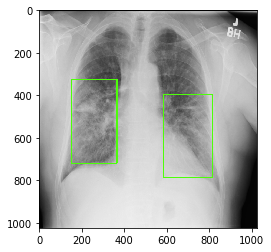

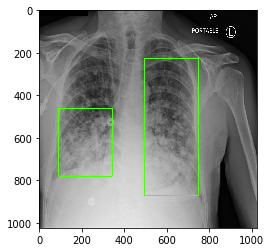

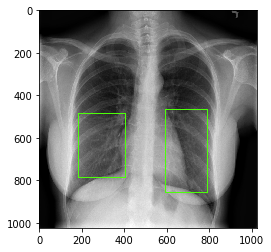

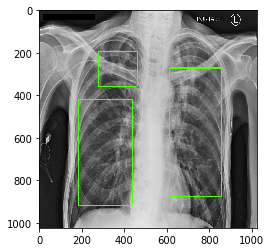

In [3]:
# Get filenames of test dataset DICOM images
test_image_fps = get_dicom_fps(test_dicom_dir)
# Make predictions on test images, write out sample submission
def predict(image_fps, filepath='submission.csv', min_conf=0.95):
    # assume square image
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    #resize_factor = ORIG_SIZE
    labelFile = 'stage_1_test_labels.csv'
    test_labels = pd.read_csv(labelFile)
    
    with open(filepath, 'w') as file:
        file.write("patientId,PredictionString\n")
      
        for image_id in tqdm(image_fps):
            patient_id = os.path.splitext(os.path.basename(image_id))[0]
            out_str = ""
            out_str += patient_id
            out_str += ","
            tmp = test_labels[test_labels['patientId']==patient_id]
            tmp = tmp['Target']==0  
            if tmp.bool():
                pass
            else:   
                ds = pydicom.read_file(image_id)
                image = ds.pixel_array
                # If grayscale. Convert to RGB for consistency.
                if len(image.shape) != 3 or image.shape[2] != 3:
                    image = np.stack((image,) * 3, -1)
                image, window, scale, padding, crop = utils.resize_image(
                    image,
                    min_dim=config.IMAGE_MIN_DIM,
                    min_scale=config.IMAGE_MIN_SCALE,
                    max_dim=config.IMAGE_MAX_DIM,
                    mode=config.IMAGE_RESIZE_MODE)

                results = model.detect([image])
                r = results[0]
                assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
                if len(r['rois']) == 0:
                    pass
                else:
                    num_instances = len(r['rois'])

                    for i in range(num_instances):
                        if r['scores'][i] > min_conf:
                            out_str += ' '
                            out_str += str(round(r['scores'][i], 2))
                            out_str += ' '

                            # x1, y1, width, height
                            x1 = r['rois'][i][1]
                            y1 = r['rois'][i][0]
                            width = r['rois'][i][3] - x1
                            height = r['rois'][i][2] - y1
                            bboxes_str = "{} {} {} {}".format(x1*resize_factor, y1*resize_factor, \
                                                               width*resize_factor, height*resize_factor)
                            out_str += bboxes_str

            file.write(out_str+"\n")

submission_fp = os.path.join(ROOT_DIR, 'classified_submission1022.csv')
predict(test_image_fps, filepath=submission_fp)
print(submission_fp)

output = pd.read_csv(submission_fp)
output.head(60)


# show a few test image detection example
def visualize(): 
    image_id = random.choice(test_image_fps)
    ds = pydicom.read_file(image_id)
    
    # original image 
    image = ds.pixel_array
    
    # assume square image 
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    
    # If grayscale. Convert to RGB for consistency.
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1) 
    resized_image, window, scale, padding, crop = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        min_scale=config.IMAGE_MIN_SCALE,
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE)

    patient_id = os.path.splitext(os.path.basename(image_id))[0]
    print(patient_id)

    results = model.detect([resized_image])
    r = results[0]
    for bbox in r['rois']: 
        print(bbox)
        x1 = int(bbox[1] * resize_factor)
        y1 = int(bbox[0] * resize_factor)
        x2 = int(bbox[3] * resize_factor)
        y2 = int(bbox[2]  * resize_factor)
        cv2.rectangle(image, (x1,y1), (x2,y2), (77, 255, 9), 3, 1)
        width = x2 - x1 
        height = y2 - y1 
        print("x {} y {} h {} w {}".format(x1, y1, width, height))
    plt.figure() 
    plt.imshow(image, cmap=plt.cm.gist_gray)
    plt.savefig(ROOT_DIR+"/"+patient_id+".png")
visualize()
visualize()
visualize()
visualize()


In [27]:
import numpy as np
# helper function to calculate IoU
def iou(box1, box2):
    x11, y11, w1, h1 = box1
    x21, y21, w2, h2 = box2
    #assert w1 * h1 > 0
    #assert w2 * h2 > 0
    x12, y12 = x11 + w1, y11 + h1
    x22, y22 = x21 + w2, y21 + h2

    area1, area2 = w1 * h1, w2 * h2
    xi1, yi1, xi2, yi2 = max([x11, x21]), max([y11, y21]), min([x12, x22]), min([y12, y22])
    
    if xi2 <= xi1 or yi2 <= yi1:
        return 0
    else:
        intersect = (xi2-xi1) * (yi2-yi1)
        union = area1 + area2 - intersect
        return intersect / union
    
# simple test
box1 = [100, 100, 200, 200]
box2 = [100, 100, 300, 200]
print(iou(box1, box2))


0.6666666666666666


In [28]:
def map_iou(boxes_true, boxes_pred, scores, thresholds = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75]):
    """
    Mean average precision at differnet intersection over union (IoU) threshold
    
    input:
        boxes_true: Mx4 numpy array of ground true bounding boxes of one image. 
                    bbox format: (x1, y1, w, h)
        boxes_pred: Nx4 numpy array of predicted bounding boxes of one image. 
                    bbox format: (x1, y1, w, h)
        scores:     length N numpy array of scores associated with predicted bboxes
        thresholds: IoU shresholds to evaluate mean average precision on
    output: 
        map: mean average precision of the image
    """
    
    # According to the introduction, images with no ground truth bboxes will not be 
    # included in the map score unless there is a false positive detection (?)
        
    # return None if both are empty, don't count the image in final evaluation (?)
    if len(boxes_true) == 0 and len(boxes_pred) == 0:
        return 0
    
    assert boxes_true.shape[1] == 4 or boxes_pred.shape[1] == 4, "boxes should be 2D arrays with shape[1]=4"
    if len(boxes_pred):
        assert len(scores) == len(boxes_pred), "boxes_pred and scores should be same length"
        # sort boxes_pred by scores in decreasing order
        boxes_pred = boxes_pred[np.argsort(scores)[::-1], :]
    
    map_total = 0
    
    # loop over thresholds
    for t in thresholds:
        matched_bt = set()
        tp, fn = 0, 0
        for i, bt in enumerate(boxes_true):
            matched = False
            for j, bp in enumerate(boxes_pred):
                miou = iou(bt, bp)
                if miou >= t and not matched and j not in matched_bt:
                    matched = True
                    tp += 1 # bt is matched for the first time, count as TP
                    matched_bt.add(j)
            if not matched:
                fn += 1 # bt has no match, count as FN
                
        fp = len(boxes_pred) - len(matched_bt) # FP is the bp that not matched to any bt
        m = tp / (tp + fn + fp)
        map_total += m
    
    return map_total / len(thresholds)
# simple test
boxes_true = np.array([[100, 100, 200, 200]])
boxes_pred = np.array([[100, 100, 300, 200]])
scores = [0.9]

map_iou(boxes_true, boxes_pred, scores)

0.75

In [29]:

def evaluate(dataset_eval):
    summ = 0.0
    # assume square image
    
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    #resize_factor = ORIG_SIZE
      
    for image_id in tqdm(dataset_eval.image_ids):
        original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset_val, inference_config, 
                                   image_id, use_mini_mask=False)
#         visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
#                                     dataset.class_names,
#                                     colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])

        results = model.detect([original_image]) #, verbose=1)
        r = results[0]
        #print(len(r['rois']),len(gt_bbox),len(r['scores']))
        #print(r['rois'],r['scores'])
        summ += map_iou(gt_bbox,r['rois'],r['scores'])
#         visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
#                                     dataset.class_names, r['scores'], 
#                                     colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])
    return summ/len(dataset_eval.image_ids)

print(evaluate(dataset_val))








  0%|          | 0/1500 [00:00<?, ?it/s]






  0%|          | 1/1500 [00:00<07:13,  3.46it/s]






  0%|          | 2/1500 [00:00<07:26,  3.36it/s]






  0%|          | 3/1500 [00:00<07:35,  3.29it/s]






  0%|          | 4/1500 [00:01<07:49,  3.19it/s]






  0%|          | 5/1500 [00:01<09:36,  2.59it/s]






  0%|          | 6/1500 [00:02<11:14,  2.22it/s]






  0%|          | 7/1500 [00:03<18:12,  1.37it/s]






  1%|          | 8/1500 [00:04<14:50,  1.68it/s]






  1%|          | 9/1500 [00:04<12:58,  1.91it/s]






  1%|          | 10/1500 [00:04<11:42,  2.12it/s]






  1%|          | 11/1500 [00:05<11:15,  2.20it/s]






  1%|          | 12/1500 [00:05<10:25,  2.38it/s]






  1%|          | 13/1500 [00:05<09:50,  2.52it/s]






  1%|          | 14/1500 [00:06<09:25,  2.63it/s]






  1%|          | 15/1500 [00:06<10:15,  2.41it/s]






  1%|          | 16/1500 [00:07<11:36,  2.13it/s]






  1%|          | 17/1500 [00:07<11:17,  2.19it/s]






  1

  7%|▋         | 106/1500 [00:42<08:21,  2.78it/s]






  7%|▋         | 107/1500 [00:42<08:56,  2.60it/s]






  7%|▋         | 108/1500 [00:43<09:35,  2.42it/s]






  7%|▋         | 109/1500 [00:43<08:50,  2.62it/s]






  7%|▋         | 110/1500 [00:43<08:46,  2.64it/s]






  7%|▋         | 111/1500 [00:44<08:36,  2.69it/s]






  7%|▋         | 112/1500 [00:44<08:14,  2.81it/s]






  8%|▊         | 113/1500 [00:44<08:53,  2.60it/s]






  8%|▊         | 114/1500 [00:45<09:11,  2.51it/s]






  8%|▊         | 115/1500 [00:45<08:30,  2.72it/s]






  8%|▊         | 116/1500 [00:46<08:10,  2.82it/s]






  8%|▊         | 117/1500 [00:46<07:51,  2.93it/s]






  8%|▊         | 118/1500 [00:46<07:24,  3.11it/s]






  8%|▊         | 119/1500 [00:46<07:47,  2.96it/s]






  8%|▊         | 120/1500 [00:47<07:44,  2.97it/s]






  8%|▊         | 121/1500 [00:47<08:01,  2.87it/s]






  8%|▊         | 122/1500 [00:48<07:53,  2.91it/s]






  8%|▊         | 123/1500 [00:4

 14%|█▍        | 211/1500 [01:23<08:01,  2.68it/s]






 14%|█▍        | 212/1500 [01:23<07:32,  2.85it/s]






 14%|█▍        | 213/1500 [01:24<07:44,  2.77it/s]






 14%|█▍        | 214/1500 [01:24<08:48,  2.43it/s]






 14%|█▍        | 215/1500 [01:25<09:17,  2.31it/s]






 14%|█▍        | 216/1500 [01:25<09:05,  2.35it/s]






 14%|█▍        | 217/1500 [01:25<09:05,  2.35it/s]






 15%|█▍        | 218/1500 [01:26<08:53,  2.40it/s]






 15%|█▍        | 219/1500 [01:26<08:17,  2.57it/s]






 15%|█▍        | 220/1500 [01:26<08:04,  2.64it/s]






 15%|█▍        | 221/1500 [01:27<07:43,  2.76it/s]






 15%|█▍        | 222/1500 [01:27<07:17,  2.92it/s]






 15%|█▍        | 223/1500 [01:28<07:56,  2.68it/s]






 15%|█▍        | 224/1500 [01:28<07:37,  2.79it/s]






 15%|█▌        | 225/1500 [01:28<07:11,  2.95it/s]






 15%|█▌        | 226/1500 [01:29<07:19,  2.90it/s]






 15%|█▌        | 227/1500 [01:29<08:09,  2.60it/s]






 15%|█▌        | 228/1500 [01:2

 21%|██        | 316/1500 [02:03<07:03,  2.80it/s]






 21%|██        | 317/1500 [02:03<07:08,  2.76it/s]






 21%|██        | 318/1500 [02:03<06:47,  2.90it/s]






 21%|██▏       | 319/1500 [02:04<07:10,  2.75it/s]






 21%|██▏       | 320/1500 [02:04<06:56,  2.83it/s]






 21%|██▏       | 321/1500 [02:05<06:58,  2.81it/s]






 21%|██▏       | 322/1500 [02:05<06:43,  2.92it/s]






 22%|██▏       | 323/1500 [02:05<06:49,  2.87it/s]






 22%|██▏       | 324/1500 [02:06<07:51,  2.50it/s]






 22%|██▏       | 325/1500 [02:06<07:29,  2.62it/s]






 22%|██▏       | 326/1500 [02:07<07:42,  2.54it/s]






 22%|██▏       | 327/1500 [02:07<07:45,  2.52it/s]






 22%|██▏       | 328/1500 [02:07<08:26,  2.32it/s]






 22%|██▏       | 329/1500 [02:08<09:28,  2.06it/s]






 22%|██▏       | 330/1500 [02:09<09:34,  2.04it/s]






 22%|██▏       | 331/1500 [02:09<09:15,  2.11it/s]






 22%|██▏       | 332/1500 [02:09<08:37,  2.26it/s]






 22%|██▏       | 333/1500 [02:1

 28%|██▊       | 421/1500 [02:43<07:14,  2.48it/s]






 28%|██▊       | 422/1500 [02:44<07:07,  2.52it/s]






 28%|██▊       | 423/1500 [02:44<07:08,  2.51it/s]






 28%|██▊       | 424/1500 [02:45<06:47,  2.64it/s]






 28%|██▊       | 425/1500 [02:45<06:17,  2.85it/s]






 28%|██▊       | 426/1500 [02:45<05:40,  3.16it/s]






 28%|██▊       | 427/1500 [02:45<05:16,  3.39it/s]






 29%|██▊       | 428/1500 [02:46<06:07,  2.92it/s]






 29%|██▊       | 429/1500 [02:46<06:16,  2.84it/s]






 29%|██▊       | 430/1500 [02:46<06:01,  2.96it/s]






 29%|██▊       | 431/1500 [02:47<05:52,  3.04it/s]






 29%|██▉       | 432/1500 [02:47<05:58,  2.98it/s]






 29%|██▉       | 433/1500 [02:48<06:25,  2.77it/s]






 29%|██▉       | 434/1500 [02:48<06:10,  2.88it/s]






 29%|██▉       | 435/1500 [02:48<05:51,  3.03it/s]






 29%|██▉       | 436/1500 [02:49<06:26,  2.75it/s]






 29%|██▉       | 437/1500 [02:49<06:35,  2.69it/s]






 29%|██▉       | 438/1500 [02:4

 35%|███▌      | 526/1500 [03:25<06:28,  2.51it/s]






 35%|███▌      | 527/1500 [03:26<06:00,  2.70it/s]






 35%|███▌      | 528/1500 [03:26<05:51,  2.77it/s]






 35%|███▌      | 529/1500 [03:26<05:50,  2.77it/s]






 35%|███▌      | 530/1500 [03:27<06:04,  2.66it/s]






 35%|███▌      | 531/1500 [03:27<05:50,  2.76it/s]






 35%|███▌      | 532/1500 [03:27<05:45,  2.80it/s]






 36%|███▌      | 533/1500 [03:28<05:38,  2.85it/s]






 36%|███▌      | 534/1500 [03:28<05:40,  2.84it/s]






 36%|███▌      | 535/1500 [03:28<05:43,  2.81it/s]






 36%|███▌      | 536/1500 [03:29<06:00,  2.68it/s]






 36%|███▌      | 537/1500 [03:29<05:45,  2.78it/s]






 36%|███▌      | 538/1500 [03:30<06:14,  2.57it/s]






 36%|███▌      | 539/1500 [03:30<06:35,  2.43it/s]






 36%|███▌      | 540/1500 [03:31<06:52,  2.33it/s]






 36%|███▌      | 541/1500 [03:31<07:54,  2.02it/s]






 36%|███▌      | 542/1500 [03:33<12:58,  1.23it/s]






 36%|███▌      | 543/1500 [03:3

 42%|████▏     | 631/1500 [04:07<06:00,  2.41it/s]






 42%|████▏     | 632/1500 [04:08<06:20,  2.28it/s]






 42%|████▏     | 633/1500 [04:08<06:06,  2.36it/s]






 42%|████▏     | 634/1500 [04:09<05:51,  2.46it/s]






 42%|████▏     | 635/1500 [04:09<05:30,  2.62it/s]






 42%|████▏     | 636/1500 [04:09<05:44,  2.51it/s]






 42%|████▏     | 637/1500 [04:10<05:32,  2.59it/s]






 43%|████▎     | 638/1500 [04:10<05:13,  2.75it/s]






 43%|████▎     | 639/1500 [04:10<05:14,  2.74it/s]






 43%|████▎     | 640/1500 [04:11<04:58,  2.88it/s]






 43%|████▎     | 641/1500 [04:11<05:14,  2.73it/s]






 43%|████▎     | 642/1500 [04:12<05:19,  2.69it/s]






 43%|████▎     | 643/1500 [04:12<05:39,  2.52it/s]






 43%|████▎     | 644/1500 [04:12<05:17,  2.70it/s]






 43%|████▎     | 645/1500 [04:13<05:24,  2.64it/s]






 43%|████▎     | 646/1500 [04:13<05:08,  2.77it/s]






 43%|████▎     | 647/1500 [04:13<04:55,  2.89it/s]






 43%|████▎     | 648/1500 [04:1

 49%|████▉     | 736/1500 [04:57<05:43,  2.22it/s]






 49%|████▉     | 737/1500 [04:58<05:41,  2.23it/s]






 49%|████▉     | 738/1500 [04:58<04:55,  2.58it/s]






 49%|████▉     | 739/1500 [04:59<04:52,  2.60it/s]






 49%|████▉     | 740/1500 [04:59<04:59,  2.53it/s]






 49%|████▉     | 741/1500 [04:59<04:50,  2.61it/s]






 49%|████▉     | 742/1500 [05:00<05:08,  2.46it/s]






 50%|████▉     | 743/1500 [05:00<05:24,  2.33it/s]






 50%|████▉     | 744/1500 [05:01<05:46,  2.18it/s]






 50%|████▉     | 745/1500 [05:01<05:26,  2.31it/s]






 50%|████▉     | 746/1500 [05:02<05:16,  2.38it/s]






 50%|████▉     | 747/1500 [05:02<05:10,  2.42it/s]






 50%|████▉     | 748/1500 [05:02<05:14,  2.39it/s]






 50%|████▉     | 749/1500 [05:03<04:49,  2.59it/s]






 50%|█████     | 750/1500 [05:03<04:45,  2.62it/s]






 50%|█████     | 751/1500 [05:03<04:35,  2.72it/s]






 50%|█████     | 752/1500 [05:04<04:44,  2.63it/s]






 50%|█████     | 753/1500 [05:0

 56%|█████▌    | 841/1500 [06:00<04:34,  2.40it/s]






 56%|█████▌    | 842/1500 [06:01<04:44,  2.31it/s]






 56%|█████▌    | 843/1500 [06:01<04:34,  2.39it/s]






 56%|█████▋    | 844/1500 [06:01<04:16,  2.56it/s]






 56%|█████▋    | 845/1500 [06:02<04:07,  2.65it/s]






 56%|█████▋    | 846/1500 [06:02<04:14,  2.57it/s]






 56%|█████▋    | 847/1500 [06:03<04:30,  2.41it/s]






 57%|█████▋    | 848/1500 [06:03<04:13,  2.58it/s]






 57%|█████▋    | 849/1500 [06:04<04:48,  2.26it/s]






 57%|█████▋    | 850/1500 [06:04<04:48,  2.25it/s]






 57%|█████▋    | 851/1500 [06:04<04:07,  2.62it/s]






 57%|█████▋    | 852/1500 [06:05<04:06,  2.63it/s]






 57%|█████▋    | 853/1500 [06:05<04:09,  2.59it/s]






 57%|█████▋    | 854/1500 [06:05<03:45,  2.87it/s]






 57%|█████▋    | 855/1500 [06:06<03:45,  2.86it/s]






 57%|█████▋    | 856/1500 [06:06<03:53,  2.76it/s]






 57%|█████▋    | 857/1500 [06:06<03:50,  2.79it/s]






 57%|█████▋    | 858/1500 [06:0

 63%|██████▎   | 946/1500 [06:55<03:47,  2.44it/s]






 63%|██████▎   | 947/1500 [06:55<03:39,  2.52it/s]






 63%|██████▎   | 948/1500 [06:56<03:31,  2.60it/s]






 63%|██████▎   | 949/1500 [06:56<03:56,  2.33it/s]






 63%|██████▎   | 950/1500 [06:57<03:52,  2.37it/s]






 63%|██████▎   | 951/1500 [06:57<04:21,  2.10it/s]






 63%|██████▎   | 952/1500 [06:58<04:27,  2.05it/s]






 64%|██████▎   | 953/1500 [06:58<04:25,  2.06it/s]






 64%|██████▎   | 954/1500 [06:59<04:06,  2.22it/s]






 64%|██████▎   | 955/1500 [06:59<03:54,  2.32it/s]






 64%|██████▎   | 956/1500 [06:59<03:44,  2.43it/s]






 64%|██████▍   | 957/1500 [07:00<03:37,  2.49it/s]






 64%|██████▍   | 958/1500 [07:00<03:33,  2.53it/s]






 64%|██████▍   | 959/1500 [07:01<03:45,  2.40it/s]






 64%|██████▍   | 960/1500 [07:01<03:59,  2.25it/s]






 64%|██████▍   | 961/1500 [07:02<03:49,  2.35it/s]






 64%|██████▍   | 962/1500 [07:02<03:42,  2.42it/s]






 64%|██████▍   | 963/1500 [07:0

 70%|███████   | 1050/1500 [07:49<02:44,  2.73it/s]






 70%|███████   | 1051/1500 [07:50<02:43,  2.75it/s]






 70%|███████   | 1052/1500 [07:50<02:32,  2.94it/s]






 70%|███████   | 1053/1500 [07:50<02:36,  2.85it/s]






 70%|███████   | 1054/1500 [07:51<02:30,  2.97it/s]






 70%|███████   | 1055/1500 [07:51<02:54,  2.55it/s]






 70%|███████   | 1056/1500 [07:52<03:13,  2.30it/s]






 70%|███████   | 1057/1500 [07:52<03:01,  2.44it/s]






 71%|███████   | 1058/1500 [07:54<06:22,  1.15it/s]






 71%|███████   | 1059/1500 [07:57<10:19,  1.40s/it]






 71%|███████   | 1060/1500 [08:01<17:13,  2.35s/it]






 71%|███████   | 1061/1500 [08:02<13:04,  1.79s/it]






 71%|███████   | 1062/1500 [08:02<09:47,  1.34s/it]






 71%|███████   | 1063/1500 [08:03<07:51,  1.08s/it]






 71%|███████   | 1064/1500 [08:03<06:13,  1.17it/s]






 71%|███████   | 1065/1500 [08:03<05:04,  1.43it/s]






 71%|███████   | 1066/1500 [08:04<05:50,  1.24it/s]






 71%|███████  

 77%|███████▋  | 1153/1500 [09:03<02:34,  2.25it/s]






 77%|███████▋  | 1154/1500 [09:04<02:34,  2.24it/s]






 77%|███████▋  | 1155/1500 [09:04<02:28,  2.33it/s]






 77%|███████▋  | 1156/1500 [09:04<02:25,  2.36it/s]






 77%|███████▋  | 1157/1500 [09:05<02:13,  2.57it/s]






 77%|███████▋  | 1158/1500 [09:05<02:13,  2.56it/s]






 77%|███████▋  | 1159/1500 [09:06<02:12,  2.57it/s]






 77%|███████▋  | 1160/1500 [09:06<02:13,  2.55it/s]






 77%|███████▋  | 1161/1500 [09:06<02:04,  2.71it/s]






 77%|███████▋  | 1162/1500 [09:08<04:18,  1.31it/s]






 78%|███████▊  | 1163/1500 [09:13<11:30,  2.05s/it]






 78%|███████▊  | 1164/1500 [09:19<17:19,  3.09s/it]






 78%|███████▊  | 1165/1500 [09:19<12:53,  2.31s/it]






 78%|███████▊  | 1166/1500 [09:19<09:38,  1.73s/it]






 78%|███████▊  | 1167/1500 [09:20<07:21,  1.33s/it]






 78%|███████▊  | 1168/1500 [09:20<05:43,  1.03s/it]






 78%|███████▊  | 1169/1500 [09:21<04:48,  1.15it/s]






 78%|███████▊ 

 84%|████████▎ | 1256/1500 [10:10<01:37,  2.49it/s]






 84%|████████▍ | 1257/1500 [10:10<01:34,  2.58it/s]






 84%|████████▍ | 1258/1500 [10:11<01:39,  2.43it/s]






 84%|████████▍ | 1259/1500 [10:11<01:35,  2.54it/s]






 84%|████████▍ | 1260/1500 [10:11<01:27,  2.75it/s]






 84%|████████▍ | 1261/1500 [10:12<01:26,  2.76it/s]






 84%|████████▍ | 1262/1500 [10:12<01:32,  2.57it/s]






 84%|████████▍ | 1263/1500 [10:13<01:38,  2.42it/s]






 84%|████████▍ | 1264/1500 [10:13<01:42,  2.30it/s]






 84%|████████▍ | 1265/1500 [10:14<01:36,  2.43it/s]






 84%|████████▍ | 1266/1500 [10:14<01:32,  2.53it/s]






 84%|████████▍ | 1267/1500 [10:14<01:41,  2.30it/s]






 85%|████████▍ | 1268/1500 [10:15<01:42,  2.25it/s]






 85%|████████▍ | 1269/1500 [10:15<01:40,  2.30it/s]






 85%|████████▍ | 1270/1500 [10:16<01:33,  2.45it/s]






 85%|████████▍ | 1271/1500 [10:16<01:33,  2.46it/s]






 85%|████████▍ | 1272/1500 [10:16<01:29,  2.55it/s]






 85%|████████▍

 91%|█████████ | 1359/1500 [11:06<01:11,  1.98it/s]






 91%|█████████ | 1360/1500 [11:07<01:13,  1.92it/s]






 91%|█████████ | 1361/1500 [11:07<01:23,  1.67it/s]






 91%|█████████ | 1362/1500 [11:08<01:17,  1.78it/s]






 91%|█████████ | 1363/1500 [11:08<01:09,  1.97it/s]






 91%|█████████ | 1364/1500 [11:09<01:07,  2.03it/s]






 91%|█████████ | 1365/1500 [11:09<01:07,  1.99it/s]






 91%|█████████ | 1366/1500 [11:10<01:09,  1.92it/s]






 91%|█████████ | 1367/1500 [11:10<01:00,  2.19it/s]






 91%|█████████ | 1368/1500 [11:11<01:00,  2.20it/s]






 91%|█████████▏| 1369/1500 [11:11<00:56,  2.31it/s]






 91%|█████████▏| 1370/1500 [11:11<00:57,  2.26it/s]






 91%|█████████▏| 1371/1500 [11:12<00:56,  2.28it/s]






 91%|█████████▏| 1372/1500 [11:12<00:58,  2.20it/s]






 92%|█████████▏| 1373/1500 [11:13<00:53,  2.38it/s]






 92%|█████████▏| 1374/1500 [11:13<00:50,  2.48it/s]






 92%|█████████▏| 1375/1500 [11:13<00:48,  2.57it/s]






 92%|█████████

 97%|█████████▋| 1462/1500 [12:09<00:24,  1.55it/s]






 98%|█████████▊| 1463/1500 [12:09<00:20,  1.78it/s]






 98%|█████████▊| 1464/1500 [12:10<00:19,  1.84it/s]






 98%|█████████▊| 1465/1500 [12:10<00:16,  2.18it/s]






 98%|█████████▊| 1466/1500 [12:11<00:17,  1.98it/s]






 98%|█████████▊| 1467/1500 [12:11<00:14,  2.32it/s]






 98%|█████████▊| 1468/1500 [12:12<00:17,  1.85it/s]






 98%|█████████▊| 1469/1500 [12:14<00:30,  1.01it/s]






 98%|█████████▊| 1470/1500 [12:14<00:25,  1.18it/s]






 98%|█████████▊| 1471/1500 [12:15<00:20,  1.44it/s]






 98%|█████████▊| 1472/1500 [12:15<00:17,  1.60it/s]






 98%|█████████▊| 1473/1500 [12:16<00:15,  1.78it/s]






 98%|█████████▊| 1474/1500 [12:16<00:13,  1.98it/s]






 98%|█████████▊| 1475/1500 [12:16<00:12,  2.05it/s]






 98%|█████████▊| 1476/1500 [12:17<00:10,  2.23it/s]






 98%|█████████▊| 1477/1500 [12:17<00:10,  2.27it/s]






 99%|█████████▊| 1478/1500 [12:18<00:09,  2.26it/s]






 99%|█████████

0.12122499999999999
